In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from pandas import DataFrame
import scipy.stats as stats
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

## Simulating the statistical distribution of a ratio

Let us start by generating 1000 pairs for numerator / denominator with 20% error.

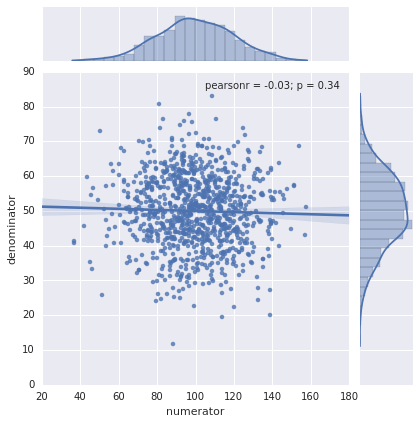

In [3]:
np.random.seed(1000)
num = np.random.normal(100, 20, size=1000)
den = np.random.normal(50, 10, size=1000)

df = DataFrame(np.column_stack((num, den)), columns=["numerator", "denominator"])
sb.jointplot("numerator", "denominator", data=df, kind="reg") #sb.jointplot(x, y, kind="reg")

Then we compute the ratio for the 1000 couple of values. Their distribution is characterized by a long tail representing overestimated values. The best-fit Gaussian distribution (in red) poorly describes the data.

mean =  2.10171277954
median =  1.99767498806


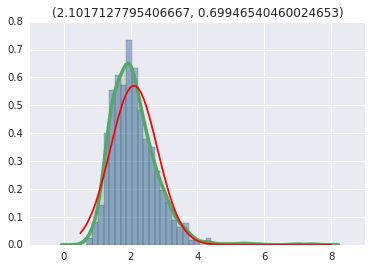

In [4]:
r = num / den
plt.hist(r, bins=40, normed=True, alpha=0.5)
sb.kdeplot(r, shade=True, lw=3.5)
# distribution fitting
param = stats.norm.fit(r)
x = np.linspace(.5,8,100)
pdf_fitted = stats.norm.pdf(x,loc=param[0],scale=param[1])
plt.plot(x,pdf_fitted,'r-')
plt.title(param)

print('mean = ', r.mean())
print('median = ', np.median(r))

Thus, the mean of the ratios is a very bad estimate; much worst than the median of the N ratio values.

In ratio imaging, as an alternative to pixel-by-pixel ratioing, it is common to take the average of a region of interest (ROI) first and subsequently calculate the ratio. In this case mean and median perform both quite well.
(with 1000 pixels and 20% error for both signals at the numerator and denominator.

In [5]:
print('mean(x)/mean(y) = ', num.mean() / den.mean())
print('median(x)/median(y) = ', np.median(num) / np.median(den))

mean(x)/mean(y) =  1.99626631033
median(x)/median(y) =  1.98373416462


### What is the best estimate in the case of 1000-pixel ROI?

All but the mean of the ratio. Possibly the sligthly better is mean Num / mean Den.

**DO NOT average the ratio!**

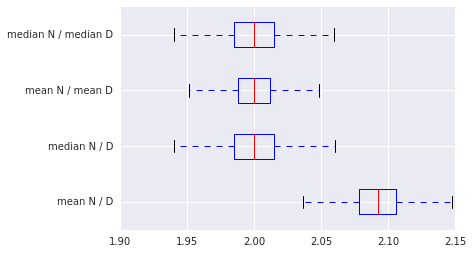

In [6]:
def ratio_sim(num, den, err_num, err_den, size, N=999):
    """Simulate the ratio between *num* and *den* in a ROI of size=*size*
    Return a df for the 4 estimates r_mean, r_median, mean_s, median_s"""
    r_mean = []
    r_median = []
    mean_s = []
    median_s = []
    for i in range(N):
        x = np.random.normal(num, err_num, size=size)
        y = np.random.normal(den, err_den, size=size)
        r = x / y
        r_mean.append(r.mean())
        r_median.append(np.median(r))
        mean_s.append(np.mean(x) / np.mean(y))
        median_s.append(np.median(x) / np.median(y))
    return DataFrame(np.column_stack((r_mean, r_median, mean_s, median_s)), 
               columns=['mean N / D', 'median N / D', 'mean N / mean D', 'median N / median D'])


df = ratio_sim(100, 50, 20, 10, 1000, 9999)
f = df.boxplot(vert=False, showfliers=False)

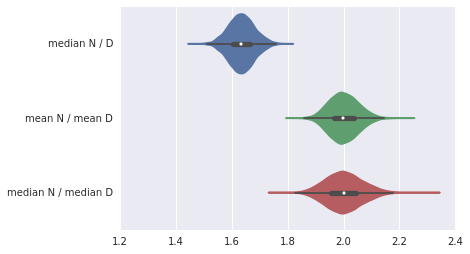

In [7]:
dfv = ratio_sim(100, 50, 20, 40, 1000, 9999)
dfv = dfv[['median N / D', 'mean N / mean D', 'median N / median D']]
sb.violinplot(dfv, vert=False, split=True, showfliers=False)

Let us move on and look at the effect of ROI size and error of the signals. Even in the presence of large error (at the denominator) the distribution of 9999 estimates replicates is nicely gaussian I will take the mean of the replicated from now on.

We may have noticed that in the presence of large error the median-of-ratio estimate is underestimating. But let's move in order.

#### Effect of the signal error

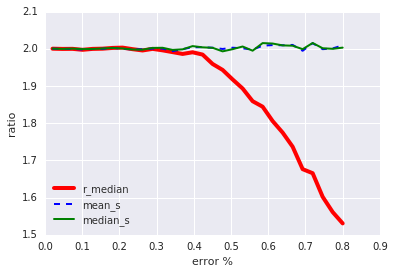

In [8]:
def plot_error(ep_ini, ep_fin, steps, num, den, size, N=999):
    """Plot all estimates but mean_r vs. the error% (same for num and den)."""
    px = np.linspace(ep_ini, ep_fin, steps)
    ave = [] # list of [r_mean, r_median, mean_s, median_s]
    sd = []
    for err in px:
        df = ratio_sim(num, den, num * err, den * err, size, N)
        ave.append(list(df.mean()))
        sd.append(list(df.std()))
    ave = np.array(ave)
    #plt.plot(px, ave[:, 0], 'k--', linewidth=2, label="Rmean")
    #plt.ylim(1.5, 3.5)
    plt.plot(px, ave[:, 1], 'r-', linewidth=4, label="r_median")
    plt.plot(px, ave[:, 2], 'b--', linewidth=2, label="mean_s")
    plt.plot(px, ave[:, 3], 'g-', linewidth=2, label="median_s")
    plt.xlabel("error %")
    plt.ylabel("ratio")
    plt.legend(loc=3)
    
plot_error(.02, .8, 30, 100, 50, 1000, 99)

#### Effect of ROI size

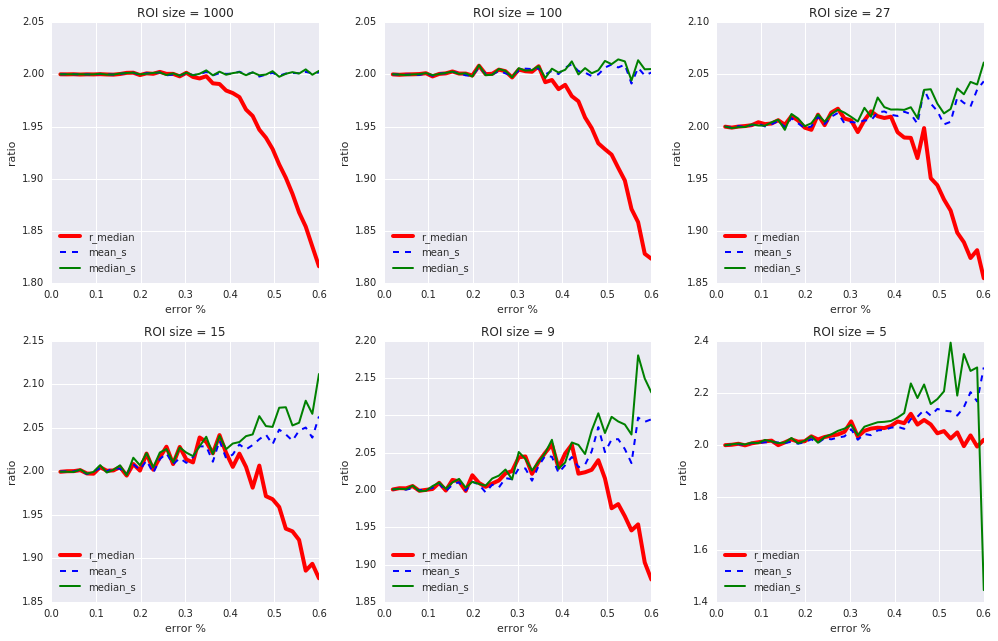

In [9]:
plt.figure(figsize=(14,9))
plt.subplot(231)
plot_error(.02, .6, 40, 100, 50, 1000, N=999)
plt.title('ROI size = 1000')

plt.subplot(232)
plot_error(.02, .6, 40, 100, 50, 100, N=999)
plt.title('ROI size = 100')

plt.subplot(233)
plot_error(.02, .6, 40, 100, 50, 27, N=999)
plt.title('ROI size = 27')

plt.subplot(234)
plot_error(.02, .6, 40, 100, 50, 15, N=999)
plt.title('ROI size = 15')

plt.subplot(235)
plot_error(.02, .6, 40, 100, 50, 9, N=999)
plt.title('ROI size = 9')

plt.subplot(236)
plot_error(.02, .6, 40, 100, 50, 5, N=999)
plt.title('ROI size = 5')

plt.tight_layout()

median_r is getting bad when the error increases (> 30-40%), but only for large ROI (>= 27 pixels).

##### error = 60%


At the ROI dimensions of common filter kernel median_r is possibly better in the presence of quite large error.

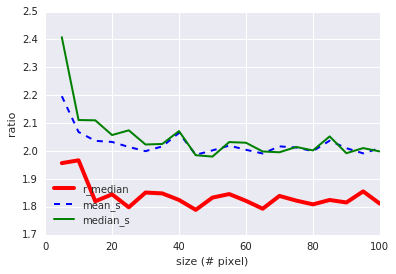

In [10]:
ps = np.linspace(5, 100, 20)
ave = [] # list of [r_mean, r_median, mean_s, median_s]
sd = []
err = .6
for s in ps:
    df = ratio_sim(100, 50, 100 * err, 50 * err, s, 99)
    ave.append(list(df.mean()))
    sd.append(list(df.std()))
ave = np.array(ave)
#plt.plot(px, ave[:, 0], 'k--', linewidth=2, label="Rmean")
#plt.ylim(1.5, 3.5)
plt.plot(ps, ave[:, 1], 'r-', linewidth=4, label="r_median")
plt.plot(ps, ave[:, 2], 'b--', linewidth=2, label="mean_s")
plt.plot(ps, ave[:, 3], 'g-', linewidth=2, label="median_s")
plt.xlabel("size (# pixel)")
plt.ylabel("ratio")
plt.legend(loc=3)

Simulations with images will follow to determine the best sequence of filters. Images with gradients should be closer to reality. What is the finest gradient that can be resolved? Probably depends on the error...

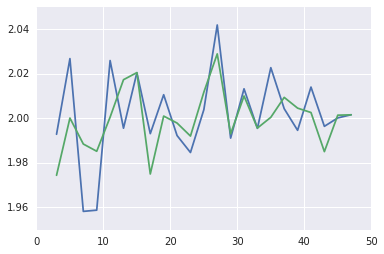

In [11]:
# want to simulate the ratio_ranking plugin

N = 9
err_rel = 0.3
SX = 100
SY = 50

def filter():
    x = np.random.normal(SX, SX * err_rel, N)
    y = np.random.normal(SY, SY * err_rel, N)
    r = x / y
    rr = []
    for xv in x:
        for yv in y:
            rr.append(xv/yv)
    return np.median(r), np.median(rr)

def sim_filters(n):
    r = []
    rr = []
    for i in range(n):
        r1, r2 = filter()
        r.append(r1)
        rr.append(r2)
    return r, rr

xl = []
m_r = []
m_rr = []
for N in range(3, 48, 2):
    xl.append(N)
    r, rr = sim_filters(400)
    m_r.append(np.median(r))
    m_rr.append(np.median(rr))

plt.plot(np.array(xl),np.array(m_r))
plt.plot(np.array(xl),np.array(m_rr))
#sns.jointplot(array(r),array(rr))
#mean(r), std(r), mean(rr), std(rr)

[Download](http://darosio.bitbucket.org/downloads/notebooks/ratio_mean_median.ipynb) this notebook.